ohio GluADFL(Ring) [21.027727832334694, 21.017894002884304, 21.091078871154874, 21.533064648473346, 22.240537738380674, 23.759015201980734] [0.051243   0.04326186 0.05303741 0.20227454 0.05238025 0.09465198]
ohio GluADFL(Cluster) [20.88698703962205, 20.936129941019, 20.99874189684445, 21.214607407224133, 21.576277875357214, 23.04169466409302] [0.00551201 0.04724296 0.03584675 0.07805826 0.12080401 0.12716004]
ohio GluADFL(Random) [20.90862985889037, 20.92546930197154, 20.984629841058727, 21.16227629748475, 21.341802233332622, 22.357480209907898] [0.06083531 0.02859714 0.03186724 0.06957036 0.04648422 0.13169899]
ohio 21.778219715868104 [21.02772783 21.017894   21.09107887 21.53306465 22.24053774 23.7590152 ]
ohio 21.442406470693314 [20.88698704 20.93612994 20.9987419  21.21460741 21.57627788 23.04169466]
ohio 21.28004795710765 [20.90862986 20.9254693  20.98462984 21.1622763  21.34180223 22.35748021]
max diff 0.49817175876045283  mg/dL
abc4d GluADFL(Ring) [20.651904851306593, 20.7218296

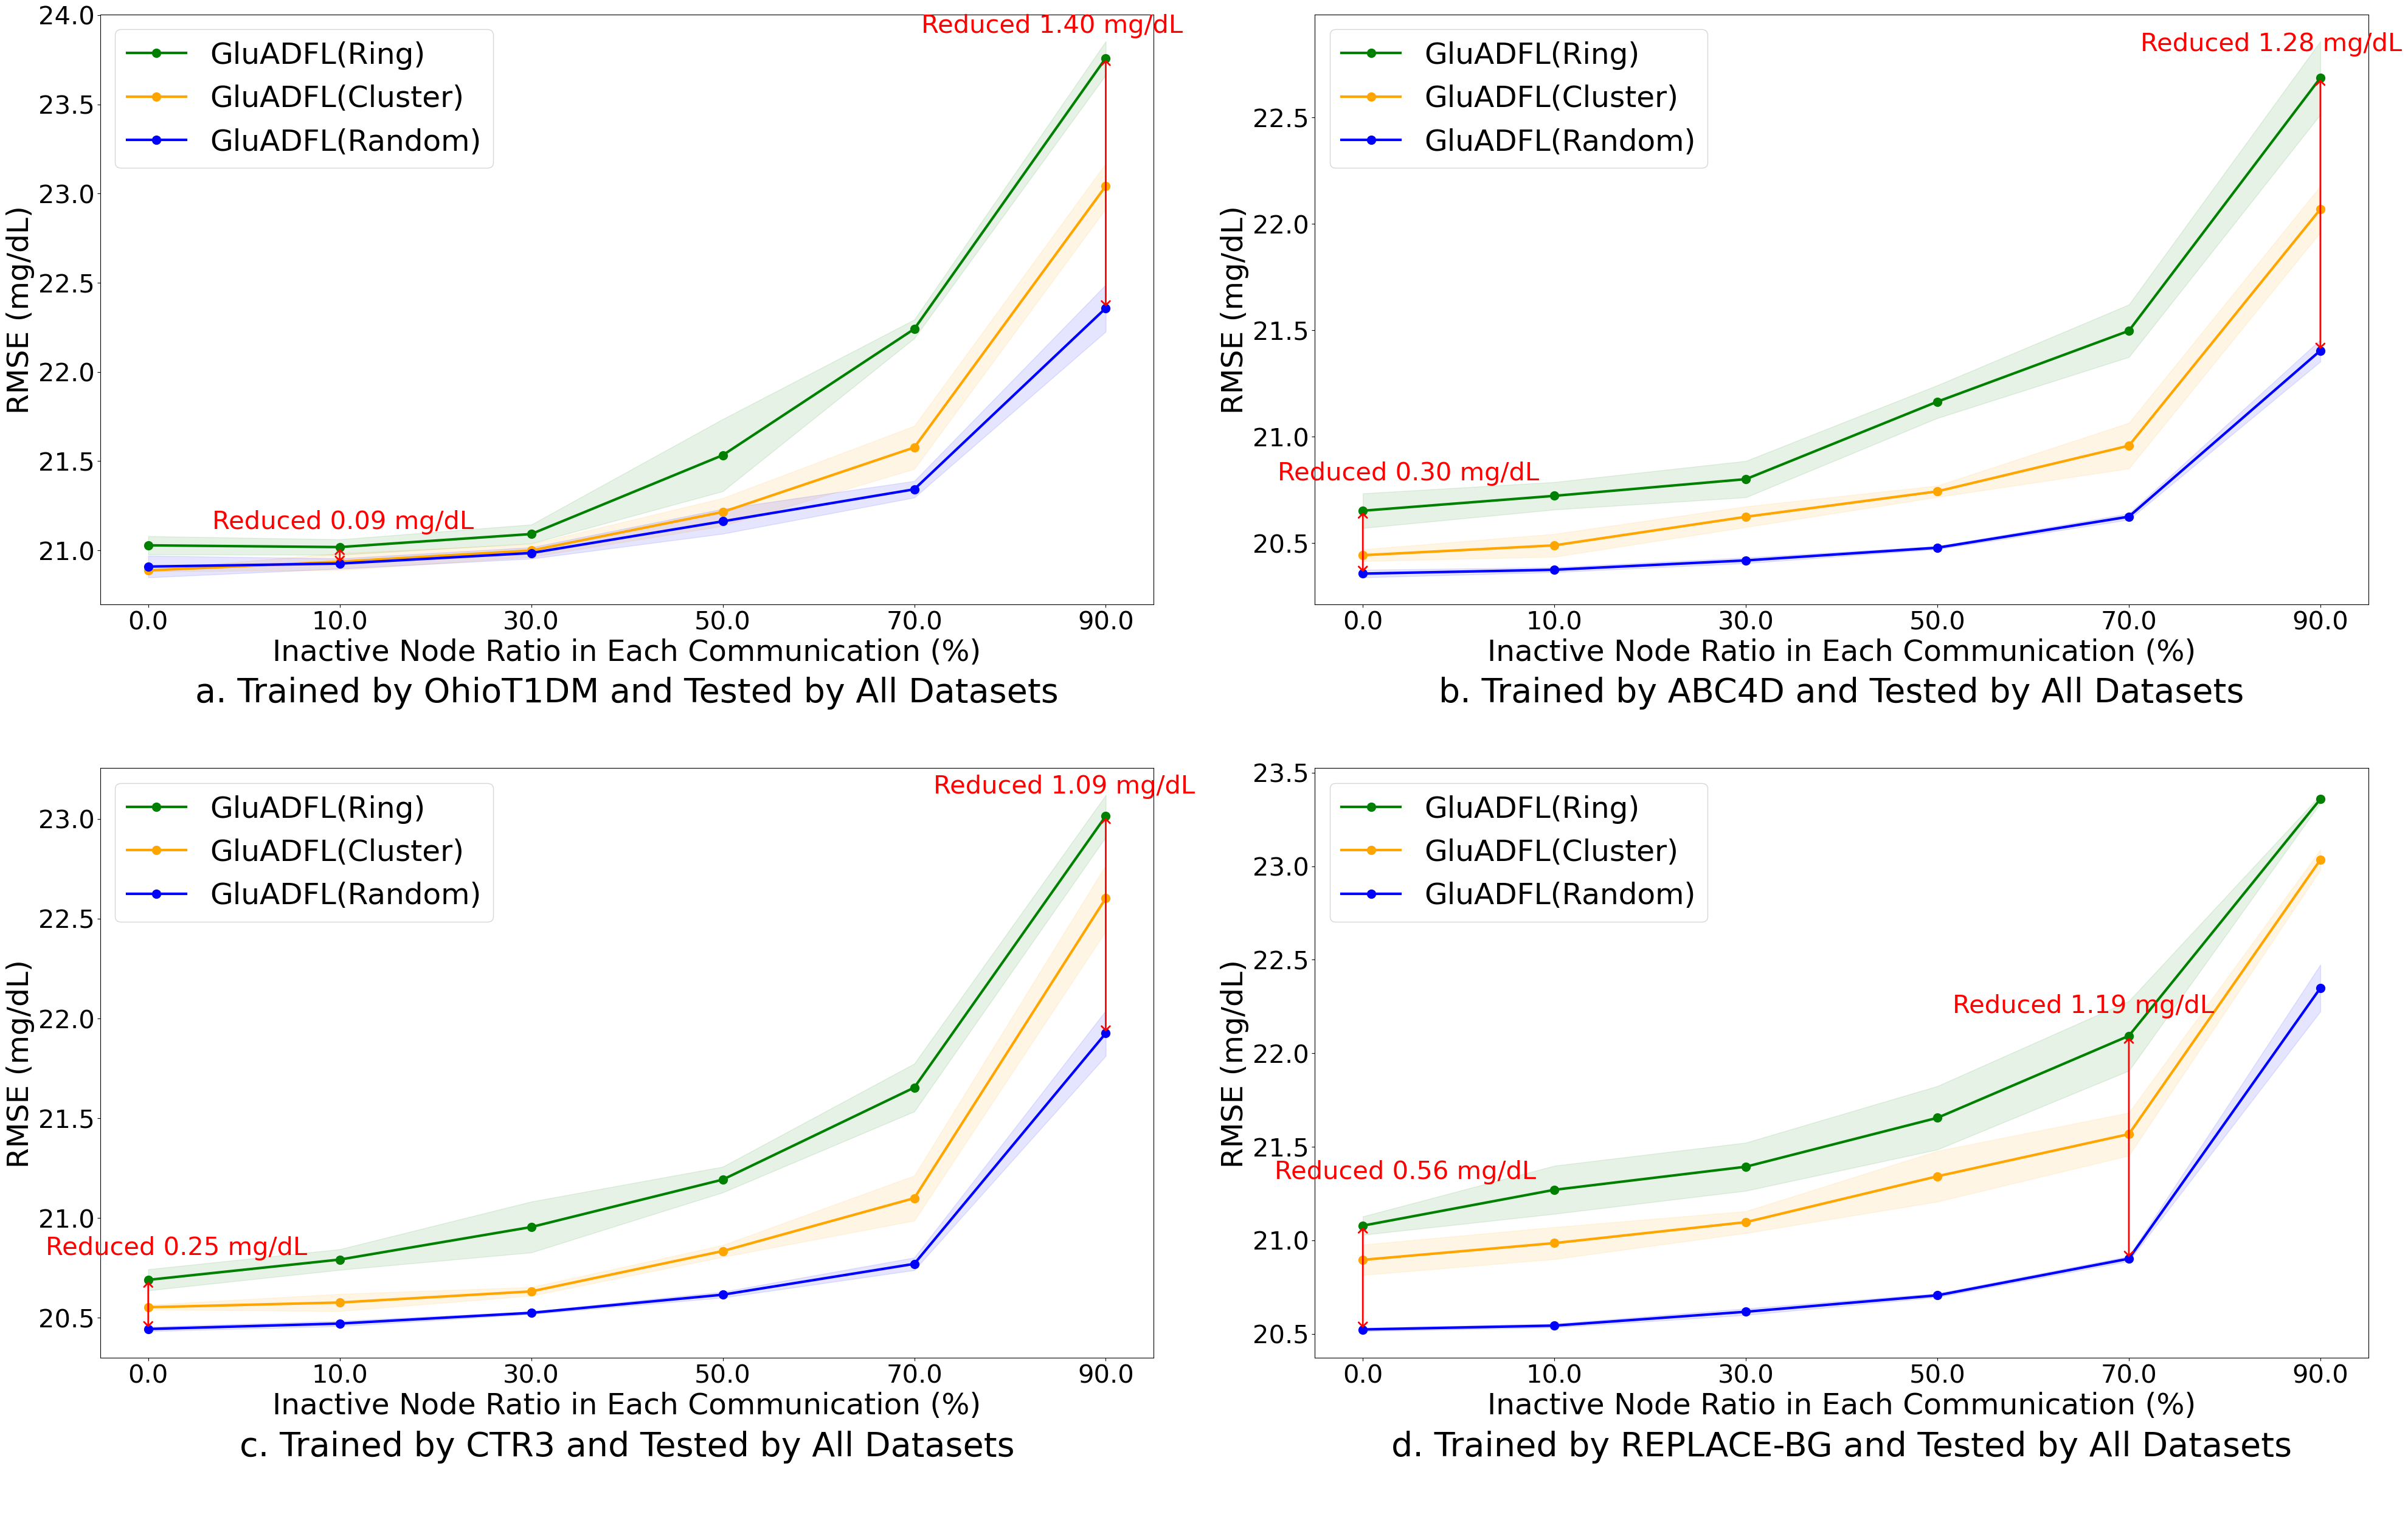

In [1]:
import xlwt
import os
import numpy as np
import matplotlib.pylab as plt
is_30 = True

mid = '_ph_60' if not is_30 else ''
method2exp = {
    'GluADFL(Ring)':('6', '9'),
    'GluADFL(Cluster)': ('8', '10'),
    # 'GluADFL+LSTM (select from all, batch=7)':('5', '15'),
    # 'GluADFL+LSTM (select from active, batch=7)':('5', '7'),
    # 'GluADFL+LSTM (select from active, batch=2)':('17', '16'),
    'GluADFL(Random)':('5', '7'),

}


dataset_list = ['ohio', 'abc4d', 'ctr3_cgm_only',  'replace-bg', ]
print_dataset = {
    'ohio': 'OhioT1DM',
    'replace-bg': 'REPLACE-BG',
    'arises': 'ARISES',
    'ctr3_cgm_only': 'CTR3',
    'abc4d': 'ABC4D',
}

print_metric = {
    'rmse' : 'RMSE',
    'mape' : 'MARD',
    'mae' : 'MAE',
    'grmse' : 'gRMSE',
    'time_lag': 'Time Lag',
}

version = 'coldstart_fl'

metric = 'rmse'

f, axs = plt.subplots(figsize = (40, 25), nrows=2, ncols=2)

axs = axs.flat

subtitles = ['a', 'b', 'c', 'd']
seeds = [1, 2, 3, 4]

offsets = [(2,8), (8,4), (6,4), (4,4)]
for r, load_dataset in enumerate(dataset_list):

    ax = axs[r]
    method2metric_mean_list = {}
    method2metric_std_list = {}
    ratio_list = ['0.0', '0.1', '0.3', '0.5', '0.7', '0.9']
    for method in method2exp:
        no1, no2 = method2exp[method]
        metric_mean_list = []
        metric_std_list = []
        for ratio in ratio_list:
            exp = no1 if ratio == '0.0' else no2
            exp = 'exp_' + exp

            if ratio != '0.0':
                exp = exp + mid + '_' + ratio
            else:
                exp = exp + mid
            seeds_rmse = []
            for seed in seeds:
                load_exp = exp + '_seed_' + str(seed) if seed != 1 else exp
                save_dict = np.load(f'D:/code_log/{version}/{load_exp}/{load_exp}.npy', allow_pickle=True)[()]
                seeds_rmse.append(save_dict[(load_dataset, metric)][0])
            metric_mean_list.append(np.mean(seeds_rmse))
            metric_std_list.append(np.std(seeds_rmse))
                
        method2metric_mean_list[method] = metric_mean_list
        method2metric_std_list[method] = metric_std_list

    color_list = ['green', 'orange', 'blue']
    method_rmse = []
    for i, method in enumerate(method2metric_mean_list):
        ax.plot(range(len(ratio_list)), method2metric_mean_list[method], 
                marker='.', 
                markersize = 20, 
                label = method, 
                # markerfacecolor = 'None', 
                # markeredgewidth=3, 
                color=color_list[i], 
                linewidth=3,
                )
        method_rmse.append(np.array(method2metric_mean_list[method]))
        lower = np.array( method2metric_mean_list[method]) - np.array(method2metric_std_list[method] )
        upper = np.array( method2metric_mean_list[method]) + np.array(method2metric_std_list[method] )
        print(load_dataset, method, method2metric_mean_list[method],  np.array(method2metric_std_list[method] ) )
        ax.fill_between(range(len(ratio_list)), lower, upper, color=color_list[i], alpha=.1)
    
    for i in range(len(method_rmse)):
        print(load_dataset, np.mean(method_rmse[i]), method_rmse[i])
    
    print('max diff', np.mean(method_rmse[0]) - np.mean(method_rmse[-1]), ' mg/dL')
    max_rmse_idx = np.argmax(method_rmse[0] - method_rmse[-1])
    # ax.annotate('Arrows', xy=(max_rmse_idx, method_rmse[-1][max_rmse_idx]), xytext=(max_rmse_idx, method_rmse[0][max_rmse_idx]),
    #         arrowprops=dict(arrowstyle='<->', color='red'))
    
    vertical_offset = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx]) * 0.1  # Adjust this factor as needed.

    # Update the annotation with adjusted text positioning and alignment.
    ax.annotate(
        '',  # Use an empty string if you don't want text but just the arrow.
        xy=(max_rmse_idx, method_rmse[-1][max_rmse_idx]),  # Pointing to
        xytext=(max_rmse_idx, method_rmse[0][max_rmse_idx]),  # Text and arrow start point
        textcoords='data',  # Coordinate system for text: 'offset points' or 'data'
        arrowprops=dict(arrowstyle='<->, head_length=0.5,head_width=0.5', lw=2, color='red'),
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
    )
    
        # Optionally, if you want to include text describing the arrow, use a separate text() call.
    # print_out_1 = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx])/method_rmse[0][max_rmse_idx] * 100
    print_out_1 = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx])
    
    ax.text(
        max_rmse_idx - vertical_offset * 2 , 
        method_rmse[0][max_rmse_idx] + vertical_offset * 0.8 ,  # Adjust this for text placement
        f'Reduced {print_out_1:.2f} mg/dL', 
        ha='center', 
        va='bottom',
        fontsize=30,  # Adjust font size as needed
        color = 'red'
    )
    
    
    max_rmse_idx = np.argmin(method_rmse[0] - method_rmse[-1])
    
    vertical_offset = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx]) * 0.1  # Adjust this factor as needed.

    # Update the annotation with adjusted text positioning and alignment.
    ax.annotate(
        '',  # Use an empty string if you don't want text but just the arrow.
        xy=(max_rmse_idx, method_rmse[-1][max_rmse_idx]),  # Pointing to
        xytext=(max_rmse_idx, method_rmse[0][max_rmse_idx]),  # Text and arrow start point
        textcoords='data',  # Coordinate system for text: 'offset points' or 'data'
        arrowprops=dict(arrowstyle='<->, head_length=0.5,head_width=0.5', lw=2, color='red'),
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
    )
    
        # Optionally, if you want to include text describing the arrow, use a separate text() call.
    # print_out_1 = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx])/method_rmse[0][max_rmse_idx] * 100
    print_out_1 = (method_rmse[0][max_rmse_idx] - method_rmse[-1][max_rmse_idx])
    
    ax.text(
        max_rmse_idx + vertical_offset * offsets[r][0] , 
        method_rmse[0][max_rmse_idx] + vertical_offset * offsets[r][1],  # Adjust this for text placement
        f'Reduced {print_out_1:.2f} mg/dL', 
        ha='center', 
        va='bottom',
        fontsize=30,  # Adjust font size as needed
        color = 'red'
    )
    
    
    
    
    ax.legend(fontsize=35)
    ax.set_xticks(ticks=range(len(ratio_list)))
    ax.set_xticklabels([f'{float(r)*100:.1f}' for r in ratio_list], fontsize=30)
    # ax.set_xticklabels([0.1, 0.3, 0.5], fontsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_xlabel(f'Inactive Node Ratio in Each Communication (%)', fontsize=35)
    ax.set_ylabel('RMSE (mg/dL)', fontsize=35 )
    ax.text(0.5, -0.15, subtitles[r] + '. Trained by ' + print_dataset[load_dataset] + ' and Tested by All Datasets', ha='center', va='center', transform=ax.transAxes, fontsize=40)
    ax.text(0.5, -0.25, ' ', ha='center', va='center', transform=ax.transAxes, fontsize=40)
    # ax.set_title(print_dataset[load_dataset], fontsize=35)
plt.tight_layout()
if is_30:
    plt.savefig(f'./summary/dead_client_ratio.pdf')  
else:
    plt.savefig(f'./summary/dead_client_ratio_ph_60.pdf')  
    
